In [2]:
 !pip install datasets

In [3]:
##---------Type the code below this line------------------##
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
from joblib import Parallel, delayed
from tqdm import tqdm
from datasets import load_dataset
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Embedding , Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

ds = load_dataset("fancyzhx/yelp_polarity")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# 2. Data Acquisition 


## 2.1 Code for converting the above downloaded data into a form suitable for DL



In [4]:
##---------Type the code below this line------------------##
print(ds)
# View the first 5 samples of the dataset
train_data = ds['train']
train_data = train_data[:5000]
test_data = ds['test']
test_data = test_data[:2000]
# Print the first 5 rows of 'text' and 'label'
for i in range(5):
    print(f"Review {i+1}: {train_data['text'][i]}")
    print(f"Label {i+1}: {train_data['label'][i]}")
    print("-" * 50)
#convert dictionary to csv data
import pandas as pd
#ds_train = pd.DataFrame(ds['train'])
#ds_test = pd.DataFrame(ds['test'])
ds_train = pd.DataFrame(train_data)
ds_test= pd.DataFrame(test_data)
ds = pd.concat([ds_train, ds_test], axis=0)
ds.to_csv('yelp.csv', index = False)
ds = pd.read_csv('yelp.csv')
print(ds.head())

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 38000
    })
})
Review 1: Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.
Label 1: 0
--------------------------------------------------
Review 2: Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st pati

In [5]:
print(ds.head())

                                                text  label
0  Unfortunately, the frustration of being Dr. Go...      0
1  Been going to Dr. Goldberg for over 10 years. ...      1
2  I don't know what Dr. Goldberg was like before...      0
3  I'm writing this review to give you a heads up...      0
4  All the food is great here. But the best thing...      1


In [6]:
ds.shape

(7000, 2)

In [7]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7000 non-null   object
 1   label   7000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 109.5+ KB


In [8]:
ds.describe()

,label
count,7000.000000
mean,0.475571
std,0.499439
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## 2.1 Write your observations from the above.

1. Size of the dataset<br>
  *Size of dataset is {'train': (560000, 2), 'test': (38000, 2)}*

2. What type of data attributes are there?<br>
 Attribute types - integer , text
3. What are you classifying?<br>
 we are perfoming sentiment analysis of the yelp polarity
4. Plot the distribution of the categories of the target / label.<br>
See below for answer



<ipython-input-9-33b805f919cd>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = ds, x = 'label' , palette= 'pastel')


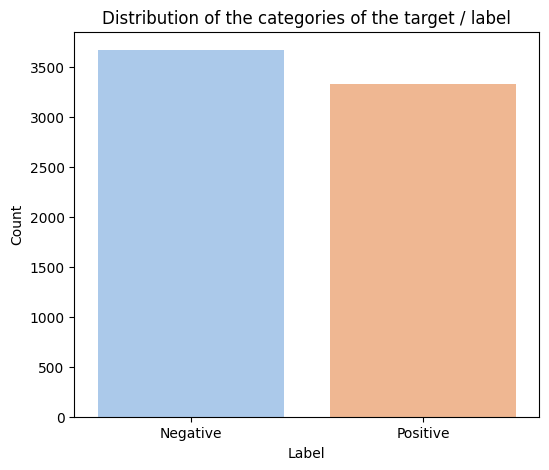

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure (figsize=(6,5))
sns.countplot(data = ds, x = 'label' , palette= 'pastel')
plt.title('Distribution of the categories of the target / label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0,1],['Negative','Positive'])
plt.show()


Insights : Data is evenly distributed

# 3. Data Preparation 

Perform the data prepracessing that is required for the data that you have downloaded.


## 3.1 Apply pre-processing techiniques

* to remove duplicate data
* to impute or remove missing data
* to remove data inconsistencies
* Encode categorical data
* Normalize the data
* Feature Engineering
* Stop word removal, lemmatiation, stemming, vectorization


IF ANY

In [10]:
##---------Type the code below this line------------------##
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [11]:
ds.head()

,text,label
0,"Unfortunately, the frustration of being Dr. Go...",0
1,Been going to Dr. Goldberg for over 10 years. ...,1
2,I don't know what Dr. Goldberg was like before...,0
3,I'm writing this review to give you a heads up...,0
4,All the food is great here. But the best thing...,1


In [12]:
ds[:5]

,text,label
0,"Unfortunately, the frustration of being Dr. Go...",0
1,Been going to Dr. Goldberg for over 10 years. ...,1
2,I don't know what Dr. Goldberg was like before...,0
3,I'm writing this review to give you a heads up...,0
4,All the food is great here. But the best thing...,1


In [13]:
from joblib import Parallel, delayed
from tqdm import tqdm
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Fast stopword removal
    return ' '.join(words)

# Apply in parallel
ds['clean_text'] = Parallel(n_jobs=-1)(
    delayed(preprocess)(text) for text in tqdm(ds['text'])
)

100%|██████████| 7000/7000 [00:38<00:00, 180.79it/s]


In [14]:
ds.head(5)
# text is preprocessed

,text,label,clean_text
0,"Unfortunately, the frustration of being Dr. Go...",0,unfortunately frustration dr goldberg patient ...
1,Been going to Dr. Goldberg for over 10 years. ...,1,going dr goldberg year think one st patient st...
2,I don't know what Dr. Goldberg was like before...,0,dont know dr goldberg like moving arizona let ...
3,I'm writing this review to give you a heads up...,0,im writing review give head see doctor office ...
4,All the food is great here. But the best thing...,1,food great best thing wing wing simply fantast...


## 3.2 Identify the target variables.

* Separate the data front the target such that the dataset is in the form of (X,y) or (Features, Label)

* Discretize / Encode the target variable or perform one-hot encoding on the target or any other as and if required.





In [15]:
ds = ds.drop('text', axis=1)
ds.head()

,label,clean_text
0,0,unfortunately frustration dr goldberg patient ...
1,1,going dr goldberg year think one st patient st...
2,0,dont know dr goldberg like moving arizona let ...
3,0,im writing review give head see doctor office ...
4,1,food great best thing wing wing simply fantast...


In [16]:
##---------Type the code below this line------------------##
# label is the target/independent varible and clean_text is the dependent feauture
X = ds.drop('label', axis=1)
y = ds['label']

X.head()
ds.head()
print(ds.shape)
print(y.head())

(7000, 2)
0    0
1    1
2    0
3    0
4    1
Name: label, dtype: int64


## 3.3 Split the data into training set and testing set

In [17]:
##---------Type the code below this line------------------##
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.head()

,clean_text
1032,awesome nuff sed
6339,pain write review giving star fairness previou...
3886,generally speaking huge fan williamssonoma ca ...
2653,little skeptical walking place loved experienc...
6914,always great place take son time cool downhe l...


## 3.4 Preprocessing report

* to remove duplicate data, if present
* to impute or remove missing data, if present
* to remove data inconsistencies, if present
* to encode categorical data
* the normalization technique used




In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [20]:
X_train_tfidf = vectorizer.fit_transform(X_train['clean_text']).toarray()

In [21]:
X_test_tfidf = vectorizer.transform(X_test['clean_text']).toarray()

In [22]:
np.set_printoptions(threshold=np.inf)
print(X_train_tfidf[:3])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

In [26]:
##---------Type the answer below this line------------------
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=100)
X_train_tfidf = vectorizer.fit_transform(X_train['clean_text']).toarray()
X_test_tfidf = vectorizer.transform(X_test['clean_text']).toarray()

# Set print options to display the full array
#np.set_printoptions(threshold=np.inf)
#print(X_train_tfidf)

# 4. Deep Neural Network Architecture 


## 4.1 Design the architecture

* Sequential Model Building with Activation for each layer.
* Add dense layers, specifying the number of units in each layer and the activation function used in the layer.
* Use Relu Activation function in each hidden layer
* Use Sigmoid / softmax Activation function in the output layer as required



In [27]:
X_train_tfidf.shape

(5600, 100)

In [28]:
##---------Type the code below this line------------------##


model_1 = Sequential([
  Dense(256, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(1, activation='sigmoid')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers
* Number of units in each layer
* Total number of trainable parameters



In [29]:
##---------Type the answer below this line------------------##
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,073 (262.00 KB)

 Trainable params: 67,073 (262.00 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Training the model 


## 5.1 Configure the training

Configure  the model for training, by using appropriate optimizers and regularizations

Compile with categorical CE loss and metric accuracy.

In [31]:
##---------Type the code below this line------------------##
import tensorflow
loss = tensorflow.keras.losses.BinaryCrossentropy()
loss
model_1.compile(optimizer= 'adam' ,loss="binary_crossentropy", metrics=['accuracy'])

## 5.2 Train the model

Train Model with cross validation, with total time taken shown for 20 epochs.

Use SGD.

In [34]:
##---------Type the code below this line------------------##
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback_1 = EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

history_1= model_1.fit(X_test_tfidf,y_test, validation_data=(X_test_tfidf,y_test), epochs=20, batch_size=32, callbacks = [early_stopping_callback_1] )

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.5732 - loss: 0.6731 - val_accuracy: 0.7557 - val_loss: 0.5246
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7409 - loss: 0.5106 - val_accuracy: 0.8064 - val_loss: 0.4199
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7882 - loss: 0.4451 - val_accuracy: 0.8243 - val_loss: 0.3998
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8312 - loss: 0.3915 - val_accuracy: 0.8507 - val_loss: 0.3508
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8643 - loss: 0.3398 - val_accuracy: 0.8729 - val_loss: 0.3093
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8665 - loss: 0.3245 - val_accuracy: 0.9364 - val_loss: 0.2153
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9489 - loss: 0.1890 - val_accuracy: 0.9736 - val_loss: 0.1397
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9645 - loss: 0.1390 - val_accuracy: 0.9829 - val_lo

Justify your choice of optimizers and regulizations used and the hyperparameters tuned


In [ ]:
##---------Type the answers below this line------------------##

# 6. Test the model 

In [36]:
##---------Type the code below this line------------------##
loss, accuracy = model_1.evaluate(X_test_tfidf, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0149
Test loss: 0.015904121100902557
Test accuracy: 0.993571400642395


# 7. Intermediate result  

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history.
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.


In [42]:
from sklearn.metrics import confusion_matrix
y_pred_probs = model_1.predict(X_test_tfidf)
y_pred_probs = np.floor(y_pred_probs)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [43]:
confusion_matrix(y_test, y_pred_probs)

array([[753,   0],
       [647,   0]])

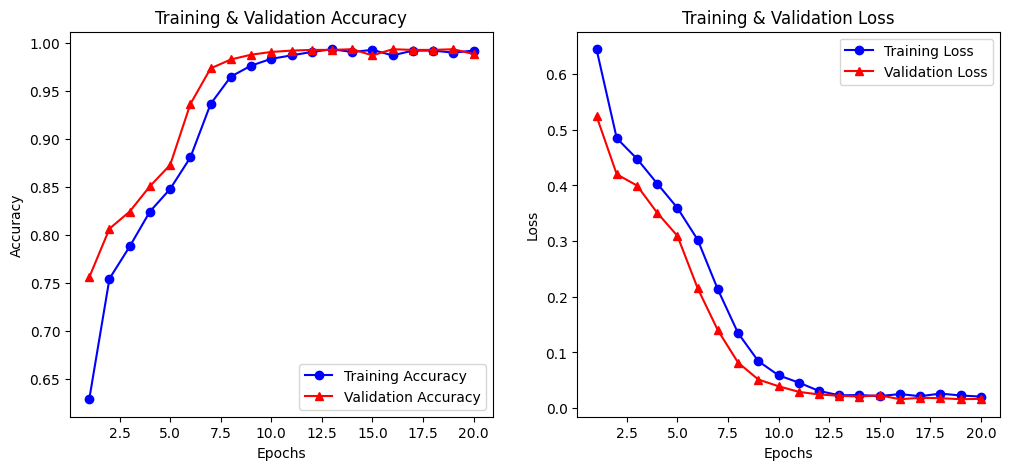

Test loss: 0.015904121100902557
Test accuracy: 0.993571400642395
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           0     0.5379    1.0000    0.6995       753
           1     0.0000    0.0000    0.0000       647

    accuracy                         0.5379      1400
   macro avg     0.2689    0.5000    0.3497      1400
weighted avg     0.2893    0.5379    0.3762      1400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
##---------Type the code below this line------------------##

import matplotlib.pyplot as plt

# Extract training history
history_dict = history_1.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

#2  Test and accuracy loss report
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

#3 Confusion matrix
from sklearn.metrics import confusion_matrix
y_pred_probs = model_1.predict(X_test_tfidf)
y_pred_probs = np.floor(y_pred_probs)
conf_matrix = confusion_matrix(y_test, y_pred_probs)

#4 Classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_probs, digits=4)
print("Classification Report:\n", report)


# 8. Model architecture


Modify the architecture designed in section 4.1

1. by decreasing one layer
2. by increasing one layer

For example, if the architecture in 4.1 has 5 layers, then 8.1 should have 4 layers and 8.2 should have 6 layers.

Plot the comparison of the training and validation accuracy of the three architecures (4.1, 8.1 and 8.2)



In [48]:
##---------Type the code below this line------------------##
#Decreasing one layer
model_2 = Sequential([
  Dense(256, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
  Dense(128, activation='relu'),
  Dense(1, activation='sigmoid')])
model_2.compile(optimizer= 'adam',loss="binary_crossentropy", metrics=['accuracy'])
early_stopping_callback_1 = EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

history_2= model_2.fit(X_test_tfidf,y_test, validation_data=(X_test_tfidf,y_test), epochs=20, batch_size=32, callbacks = [early_stopping_callback_1] )

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6013 - loss: 0.6705 - val_accuracy: 0.7600 - val_loss: 0.5548
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7679 - loss: 0.5219 - val_accuracy: 0.7786 - val_loss: 0.4607
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7615 - loss: 0.4554 - val_accuracy: 0.8114 - val_loss: 0.4130
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8041 - loss: 0.4134 - val_accuracy: 0.8250 - val_loss: 0.3836
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8265 - loss: 0.3671 - val_accuracy: 0.8529 - val_loss: 0.3549
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8599 - loss: 0.3390 - val_accuracy: 0.8700 - val_loss: 0.3130
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8595 - loss: 0.3224 - val_accuracy: 0.9114 - val_loss: 0.2652
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9075 - loss: 0.2584 - val_accuracy: 0.9471 - val_loss: 0.2076
Ep

In [49]:
#increasing one layer
model_3= Sequential([
  Dense(256, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(32, activation='relu'),
  Dense(1, activation='sigmoid')])
model_3.compile(optimizer= 'adam' ,loss="binary_crossentropy", metrics=['accuracy'])
early_stopping_callback_3 = EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

history_3 = model_3.fit(X_test_tfidf,y_test, validation_data=(X_test_tfidf,y_test), epochs=20, batch_size=32, callbacks = [early_stopping_callback_3] )

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5711 - loss: 0.6777 - val_accuracy: 0.7464 - val_loss: 0.5659
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7564 - loss: 0.5338 - val_accuracy: 0.7921 - val_loss: 0.4470
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7939 - loss: 0.4456 - val_accuracy: 0.8350 - val_loss: 0.3860
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8355 - loss: 0.3941 - val_accuracy: 0.8471 - val_loss: 0.3581
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8478 - loss: 0.3544 - val_accuracy: 0.9157 - val_loss: 0.2657
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9018 - loss: 0.2599 - val_accuracy: 0.9429 - val_loss: 0.2064
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9441 - loss: 0.1948 - val_accuracy: 0.9743 - val_loss: 0.1081
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9729 - loss: 0.1218 - val_accuracy: 0.9829 - val_loss: 0.0689
Ep

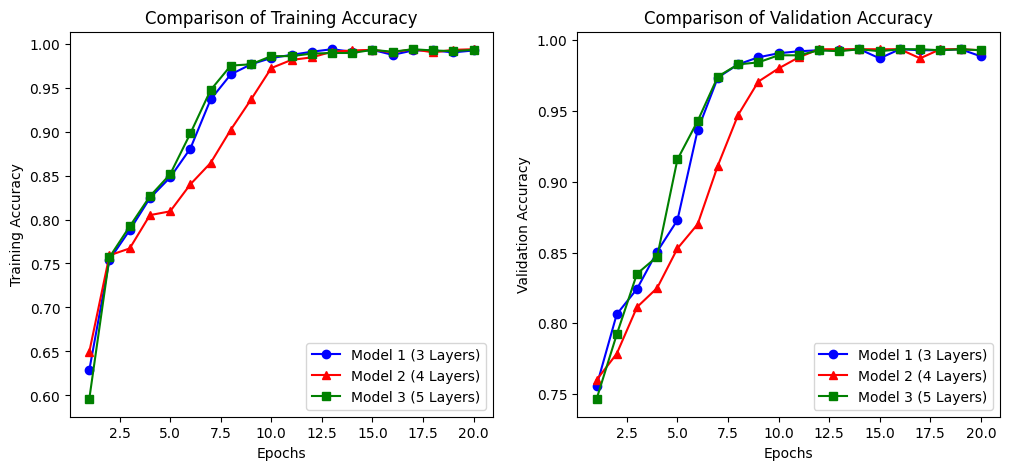

In [50]:
# Extract history
epochs_1 = range(1, len(history_1.history['accuracy']) + 1)
epochs_2 = range(1, len(history_2.history['accuracy']) + 1)
epochs_3 = range(1, len(history_3.history['accuracy']) + 1)

train_acc_1, val_acc_1 = history_1.history['accuracy'], history_1.history['val_accuracy']
train_acc_2, val_acc_2 = history_2.history['accuracy'], history_2.history['val_accuracy']
train_acc_3, val_acc_3 = history_3.history['accuracy'], history_3.history['val_accuracy']

# Plot Training Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_1, train_acc_1, 'bo-', label='Model 1 (3 Layers)')
plt.plot(epochs_2, train_acc_2, 'r^-', label='Model 2 (4 Layers)')
plt.plot(epochs_3, train_acc_3, 'gs-', label='Model 3 (5 Layers)')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Training Accuracy')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_1, val_acc_1, 'bo-', label='Model 1 (3 Layers)')
plt.plot(epochs_2, val_acc_2, 'r^-', label='Model 2 (4 Layers)')
plt.plot(epochs_3, val_acc_3, 'gs-', label='Model 3 (5 Layers)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Validation Accuracy')
plt.legend()

plt.show()



# 9. Regularisations 

Modify the architecture designed in section 4.1

1. Dropout of ratio 0.25
2. Dropout of ratio 0.25 with L2 regulariser with factor 1e−04.

Plot the comparison of the training and validation accuracy of the three (4.1, 9.1 and 9.2)



In [60]:
##---------Type the code below this line------------------##
# Define the model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam


# Model 9.1 (Dropout 0.25)
model_9_1 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

model_9_1.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

early_stopping_9_1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_9_1 = model_9_1.fit(
    X_train_tfidf, y_train,
    validation_data=(X_test_tfidf, y_test),
    epochs=20, batch_size=32, callbacks=[early_stopping_9_1]
)




Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5107 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5229 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5261 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5202 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5276 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5114 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5232 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

In [61]:
# Model 9.2 (Dropout 0.25 + L2 Regularization 1e−4)
model_9_2 = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4), input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.25),
    Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.25),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

model_9_2.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

early_stopping_9_2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_9_2 = model_9_2.fit(
    X_train_tfidf, y_train,
    validation_data=(X_test_tfidf, y_test),
    epochs=20, batch_size=32, callbacks=[early_stopping_9_2]
)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5110 - loss: 0.0651 - val_accuracy: 0.5379 - val_loss: 0.4158
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5125 - loss: 0.7519 - val_accuracy: 0.5379 - val_loss: 2.1986
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5225 - loss: 2.9100 - val_accuracy: 0.5379 - val_loss: 5.4427
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5208 - loss: 6.5163 - val_accuracy: 0.5379 - val_loss: 10.0075
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5211 - loss: 11.3813 - val_accuracy: 0.5379 - val_loss: 15.8136
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5316 - loss: 17.4857 - val_accuracy: 0.5379 - val_loss: 22.7579
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5222 - loss: 24.6738 - val_accuracy: 0.5379 - val_loss: 30.7723
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5262 - loss: 32.9702 - val_accu

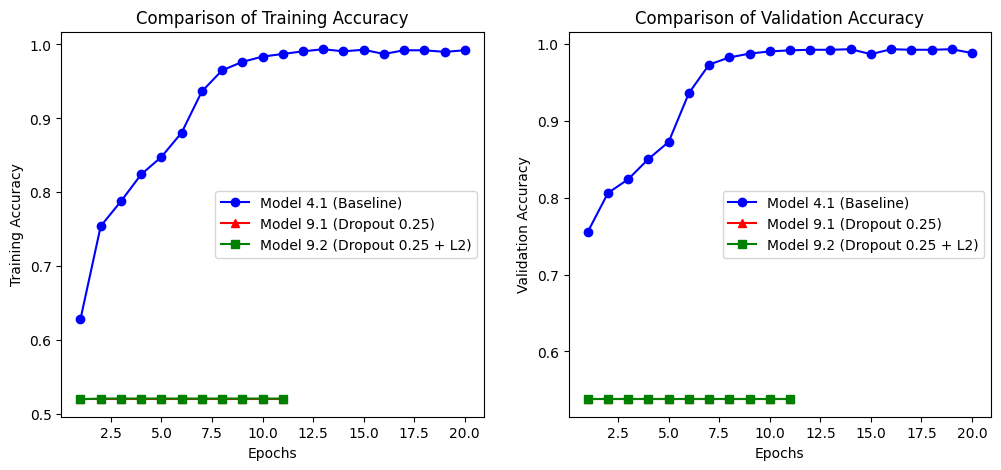

In [64]:
# Extract history
epochs_1 = range(1, len(history_1.history['accuracy']) + 1)
epochs_9_1 = range(1, len(history_9_1.history['accuracy']) + 1)
epochs_9_2 = range(1, len(history_9_2.history['accuracy']) + 1)

train_acc_1, val_acc_1 = history_1.history['accuracy'], history_1.history['val_accuracy']
train_acc_9_1, val_acc_9_1 = history_9_1.history['accuracy'], history_9_1.history['val_accuracy']
train_acc_9_2, val_acc_9_2 = history_9_2.history['accuracy'], history_9_2.history['val_accuracy']

# Plot Training Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_1, train_acc_1, 'bo-', label='Model 4.1 (Baseline)')
plt.plot(epochs_9_1, train_acc_9_1, 'r^-', label='Model 9.1 (Dropout 0.25)')
plt.plot(epochs_9_2, train_acc_9_2, 'gs-', label='Model 9.2 (Dropout 0.25 + L2)')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Training Accuracy')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_1, val_acc_1, 'bo-', label='Model 4.1 (Baseline)')
plt.plot(epochs_9_1, val_acc_9_1, 'r^-', label='Model 9.1 (Dropout 0.25)')
plt.plot(epochs_9_2, val_acc_9_2, 'gs-', label='Model 9.2 (Dropout 0.25 + L2)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Validation Accuracy')
plt.legend()

plt.show()


# 10. Optimisers 

Modify the code written in section 5.2

1. RMSProp with your choice of hyper parameters
2. Adam with your choice of hyper parameters

Plot the comparison of the training and validation accuracy of the three (5.2, 10.1 and 10.2)


In [68]:
##---------Type the code below this line------------------##

model_10_1 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

rmsprop_optimizer = RMSprop(learning_rate=0.001, rho=0.9)

model_10_1.compile(optimizer=rmsprop_optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

early_stopping_10_1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_10_1 = model_10_1.fit(
    X_train_tfidf, y_train,
    validation_data=(X_test_tfidf, y_test),
    epochs=20, batch_size=32, callbacks=[early_stopping_10_1]
)

# Model 10.2 (Adam Optimizer with Custom Hyperparameters)
model_10_2 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

adam_optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

model_10_2.compile(optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

early_stopping_10_2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_10_2 = model_10_2.fit(
    X_train_tfidf, y_train,
    validation_data=(X_test_tfidf, y_test),
    epochs=20, batch_size=32, callbacks=[early_stopping_10_2]
)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5235 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5170 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5258 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5264 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5202 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5109 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5187 - loss: 0.0000e+00 - val_accuracy: 0.5379 - val_loss: 0.0000e+00
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

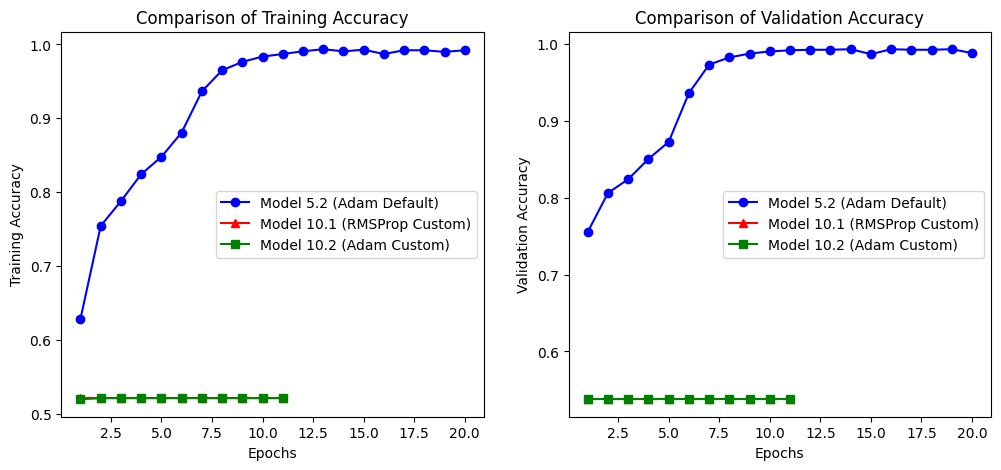

In [69]:
# Extract history
epochs_1 = range(1, len(history_1.history['accuracy']) + 1)
epochs_10_1 = range(1, len(history_10_1.history['accuracy']) + 1)
epochs_10_2 = range(1, len(history_10_2.history['accuracy']) + 1)

train_acc_1, val_acc_1 = history_1.history['accuracy'], history_1.history['val_accuracy']
train_acc_10_1, val_acc_10_1 = history_10_1.history['accuracy'], history_10_1.history['val_accuracy']
train_acc_10_2, val_acc_10_2 = history_10_2.history['accuracy'], history_10_2.history['val_accuracy']

# Plot Training Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_1, train_acc_1, 'bo-', label='Model 5.2 (Adam Default)')
plt.plot(epochs_10_1, train_acc_10_1, 'r^-', label='Model 10.1 (RMSProp Custom)')
plt.plot(epochs_10_2, train_acc_10_2, 'gs-', label='Model 10.2 (Adam Custom)')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Training Accuracy')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_1, val_acc_1, 'bo-', label='Model 5.2 (Adam Default)')
plt.plot(epochs_10_1, val_acc_10_1, 'r^-', label='Model 10.1 (RMSProp Custom)')
plt.plot(epochs_10_2, val_acc_10_2, 'gs-', label='Model 10.2 (Adam Custom)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Validation Accuracy')
plt.legend()

plt.show()
